In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras
from tensorflow.keras import backend as k
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import glob
import numpy as np
import json

In [2]:
def get_datagen():    
    datagen = ImageDataGenerator(
        #rescale=1./255,
        rotation_range=16,
        width_shift_range=0.1,
        height_shift_range=0.1,
#         horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.1
    )
    test_datagen = ImageDataGenerator(
        #rescale=1./255,
    )
    return datagen,test_datagen

In [3]:
def get_data(train_datagen,test_datagen):
    train_it = train_datagen.flow_from_directory('Splitted_Dataset_2/train', class_mode='categorical',target_size=(224, 224))

    test_it = test_datagen.flow_from_directory('Splitted_Dataset_2/test', class_mode='categorical',target_size=(224, 224))
    return train_it,test_it

In [4]:
datagen,test_datagen=get_datagen()
train_it,test_it=get_data(datagen,test_datagen)

Found 1610 images belonging to 52 classes.
Found 264 images belonging to 52 classes.


In [5]:
def get_vgg():
    vgg19 = tf.keras.applications.vgg19
    vgg = vgg19.VGG19(weights='imagenet',include_top=False,input_shape=(224,224,3))
    print(vgg.summary())
    return vgg

In [6]:
def get_InceptionV3():
    from tensorflow.keras.applications import InceptionV3
    vgg = InceptionV3(weights='imagenet',include_top=False,input_shape=(224,224,3),pooling='avg')
    for i in range(0,len(vgg.layers)-20):
        vgg.layers[i].trainable = False
    vgg.summary()
    return vgg

In [13]:
def get_model(vgg): 
    
    x = tf.keras.layers.Flatten()(vgg.output)
    # three hidden layers
    x = tf.keras.layers.Dense(256, activation='selu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    # final softmax layer with two categories (dog and cat)
    predictions = tf.keras.layers.Dense(52, activation='softmax')(x)
    model = tf.keras.Model(inputs=vgg.input,outputs=predictions)
    model.summary()
    return model


In [8]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
def train(ep):
    model = get_InceptionV3()
    model=get_model(model)
    model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adamax(),
                      metrics=['acc'])
    history = model.fit(train_it, epochs = ep,steps_per_epoch=16, validation_data=test_it, validation_steps=8)
    return model,history

In [10]:
def save_model(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")

In [15]:
def get_model():
    #Reading the model from JSON file
    with open('model.json', 'r') as json_file:
        json_savedModel= json_file.read()

    
    model = tf.keras.models.model_from_json(json_savedModel)
    model.load_weights('model.h5')
    return model

In [14]:
model,history = train(25)

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

 batch_normalization_99 (BatchN  (None, 25, 25, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 25, 25, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 25, 25, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 25, 25, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 25, 25, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 25, 25, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 12, 12, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 12, 12, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 12, 12, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_149[0][0]']
          

                                                                                                  
 batch_normalization_159 (Batch  (None, 12, 12, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 12, 12, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 12, 12, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_170 (Batch  (None, 5, 5, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_177[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 5, 5, 192)   576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 5, 5, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 

 Normalization)                                                                                   
                                                                                                  
 activation_102 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_102[0][0]']
                                                                                                  
 conv2d_100 (Conv2D)            (None, 25, 25, 48)   9216        ['max_pooling2d_5[0][0]']        
                                                                                                  
 conv2d_103 (Conv2D)            (None, 25, 25, 96)   55296       ['activation_102[0][0]']         
                                                                                                  
 batch_normalization_100 (Batch  (None, 25, 25, 48)  144         ['conv2d_100[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_112 (Conv2D)            (None, 25, 25, 64)   16384       ['average_pooling2d_10[0][0]']   
                                                                                                  
 batch_normalization_106 (Batch  (None, 25, 25, 64)  192         ['conv2d_106[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_108 (Batch  (None, 25, 25, 64)  192         ['conv2d_108[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_111 (Batch  (None, 25, 25, 96)  288         ['conv2d_111[0][0]']             
 Normaliza

                                                                  'activation_119[0][0]']         
                                                                                                  
 conv2d_121 (Conv2D)            (None, 25, 25, 64)   18432       ['mixed2[0][0]']                 
                                                                                                  
 batch_normalization_121 (Batch  (None, 25, 25, 64)  192         ['conv2d_121[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_121 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_121[0][0]']
                                                                                                  
 conv2d_122 (Conv2D)            (None, 25, 25, 96)   55296       ['activation_121[0][0]']         
          

 conv2d_127 (Conv2D)            (None, 12, 12, 192)  172032      ['activation_126[0][0]']         
                                                                                                  
 conv2d_132 (Conv2D)            (None, 12, 12, 192)  172032      ['activation_131[0][0]']         
                                                                                                  
 conv2d_133 (Conv2D)            (None, 12, 12, 192)  147456      ['average_pooling2d_12[0][0]']   
                                                                                                  
 batch_normalization_124 (Batch  (None, 12, 12, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_127 (Batch  (None, 12, 12, 192)  576        ['conv2d_127[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_134 (Batch  (None, 12, 12, 192)  576        ['conv2d_134[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_137 (Batch  (None, 12, 12, 192)  576        ['conv2d_137[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_142 (Batch  (None, 12, 12, 192)  576        ['conv2d_142[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_152 (Batch  (None, 12, 12, 192)  576        ['conv2d_152[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_153 (Batch  (None, 12, 12, 192)  576        ['conv2d_153[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_144 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_144[0][0]']
                                                                                                  
 activatio

 batch_normalization_163 (Batch  (None, 12, 12, 192)  576        ['conv2d_163[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_154 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_154[0][0]']
                                                                                                  
 activation_157 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_157[0][0]']
                                                                                                  
 activation_162 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_162[0][0]']
                                                                                                  
 activation_163 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_163[0][0]']
          

 activation_175 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 conv2d_172 (Conv2D)            (None, 5, 5, 384)    442368      ['activation_171[0][0]']         
                                                                                                  
 conv2d_173 (Conv2D)            (None, 5, 5, 384)    442368      ['activation_171[0][0]']         
                                                                                                  
 conv2d_176 (Conv2D)            (None, 5, 5, 384)    442368      ['activation_175[0][0]']         
                                                                                                  
 conv2d_177 (Conv2D)            (None, 5, 5, 384)    442368      ['activation_175[0][0]']         
                                                                                                  
 average_p

 conv2d_185 (Conv2D)            (None, 5, 5, 384)    442368      ['activation_184[0][0]']         
                                                                                                  
 conv2d_186 (Conv2D)            (None, 5, 5, 384)    442368      ['activation_184[0][0]']         
                                                                                                  
 average_pooling2d_17 (AverageP  (None, 5, 5, 2048)  0           ['mixed9[0][0]']                 
 ooling2D)                                                                                        
                                                                                                  
 conv2d_179 (Conv2D)            (None, 5, 5, 320)    655360      ['mixed9[0][0]']                 
                                                                                                  
 batch_normalization_181 (Batch  (None, 5, 5, 384)   1152        ['conv2d_181[0][0]']             
 Normaliza

Epoch 13/25
16/16 [==============================] - 16s 989ms/step - loss: 1.6393 - acc: 0.5098 - val_loss: 1.4500 - val_acc: 0.5742
Epoch 14/25
16/16 [==============================] - 16s 990ms/step - loss: 1.6181 - acc: 0.5625 - val_loss: 1.5055 - val_acc: 0.5664
Epoch 15/25
16/16 [==============================] - 16s 974ms/step - loss: 1.6252 - acc: 0.5143 - val_loss: 1.3204 - val_acc: 0.5898
Epoch 16/25
16/16 [==============================] - 16s 1s/step - loss: 1.6467 - acc: 0.4961 - val_loss: 1.3642 - val_acc: 0.5703
Epoch 17/25
16/16 [==============================] - 16s 1s/step - loss: 1.5675 - acc: 0.5430 - val_loss: 1.3201 - val_acc: 0.6016
Epoch 18/25
16/16 [==============================] - 16s 1s/step - loss: 1.4964 - acc: 0.5469 - val_loss: 1.0973 - val_acc: 0.6406
Epoch 19/25
16/16 [==============================] - 16s 1s/step - loss: 1.4258 - acc: 0.5762 - val_loss: 1.1677 - val_acc: 0.6445
Epoch 20/25
16/16 [==============================] - 16s 1s/step - loss: 1

In [16]:
save_model(model)

In [17]:
model=get_model()

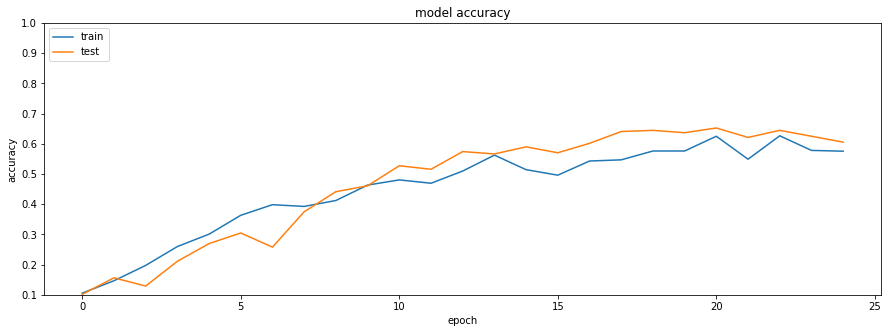

In [18]:
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.1,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()